In [1]:
import os
import json 

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

import xarray as xr
import nc_time_axis

from SALib import ProblemSpec

from src.sobol_sa import wbm_sobol
from utils.global_paths import project_data_path, project_code_path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# For plots
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['text.usetex'] = False
plt.rcParams["font.size"] = 10
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

obs_colors = {'SMAP':"#e7298a", 'VIC':"#d95f02", 'NOAH':"#7570b3", 'MOSAIC':"#1b9e77"}

groups_ag = {'Soil': ['awCap', 'wiltingp'],
             'Snow': ['Tm', 'Ts'],
             'Evapotranspiration': ['alpha', 'c_lai', 'Kmax', 'Kmin', 'Kc_end', 'Kc_mid', 'Kc_ini'],
             'Growing Season': ['L_mid', 'L_dev', 'L_ini', 'GS_end', 'GS_start'],
             'Water': ['betaHBV']}

groups_nonag = {'Soil': ['awCap', 'wiltingp'],
                'Snow': ['Tm', 'Ts'],
                'Evapotranspiration': ['alpha', 'c_lai', 'Kmax', 'Kmin'],
                'Water': ['betaHBV']}

# Preliminaries

In [3]:
def store_params(param_dict, N, experiment_name):
    #########################
    # Problem spec for SAlib
    #########################
    param_names = list(param_dict.keys())
    n_params = len(param_names)

    # Check if done
    if not os.path.isfile(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt"):
        sp = ProblemSpec({
            'num_vars': n_params,
            'names': param_names,
            'bounds': [param_dict[param] for param in param_names]
        }).sample_sobol(N)
    
        np.savetxt(f"{project_data_path}/WBM/SA/{experiment_name}_params.txt", sp.samples)
    else:
        print('Parameter file already exists!')

In [4]:
# Plotting function: hist
def make_hist_plot(obs, experiment, save_name):
    # Historical
    df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs}_noCC_res.csv')
    df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs}_noCC_res.csv')
    df_N4096 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs}_noCC_res.csv')

    # Get params
    params = df_N1024['param'].unique()
    n_params = len(params)

    # Get metrics 
    metrics = df_N1024['metric'].unique()

    ######### Plot
    fig, axs = plt.subplots(nrows=int(np.ceil(len(metrics)/3)), ncols=3,
                            figsize=(15,int(np.ceil(len(metrics)/3))*3),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.8))
    axs = axs.flatten()

    # Loop through all
    for ix, metric in enumerate(metrics):
        for id, data in enumerate([df_N1024, df_N2048, df_N4096]):
            axs[ix].bar(x=np.arange(id, (n_params*4) + id, 4),
                        height=data[data.metric == metric]['ST'],
                        yerr=data[data.metric == metric]['ST_conf'],
                        color=f'C{id}')

        # Tidy
        axs[ix].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
        axs[ix].set_title(metric)
        axs[ix].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(obs, y=0.95, fontweight='bold')

    # Remove unused axes
    unused = int(np.ceil(len(metrics)/3))*3 - len(metrics)
    if unused > 0:
        for ix in range(1,unused+1):
            axs[-ix].axis('off')

    if save_name:
        plt.savefig(f"{project_code_path}/figs/{save_name}.png", dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [5]:
# Plotting function: future
def make_future_plot(obs, metric, experiment):
    # Read CC realizations
    data_all = {}
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = pd.read_csv(f"{project_data_path}/WBM/SA/{experiment}_{read_name}_res.csv")
                data_all[read_name] = df

    # Get params
    params = data_all[read_name]['param'].unique()
    n_params = len(params)

    ######### Plot
    fig, axs = plt.subplots(nrows=4, ncols=4,
                            figsize=(15,14),
                            sharey=True, sharex=False, gridspec_kw=dict(hspace=0.75))

    # Loop through all
    for ixt, tas_delta in enumerate([-5, 1, 5, 10]):
        for ixp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
            for ixn, N in enumerate([1024, 2048, 4096]):
                # Grab df
                read_name = f"{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                df = data_all[read_name]
                
                # Plot
                axs[ixt, ixp].bar(x=np.arange(ixn, (n_params*4) + ixn, 4),
                                  height=df[df.metric == metric]['ST'],
                                  yerr=df[df.metric == metric]['ST_conf'],
                                  color=f'C{ixn}')

            # Tidy
            axs[ixt, ixp].set_xticks(np.arange(1, (n_params*4) + 1, 4), params, rotation=90)
            axs[ixt, ixp].set_title(f'tas delta: {str(tas_delta)}C, prcp factor: {str(prcp_factor)}')
            axs[ixt, ixp].grid(alpha=0.1)

    # Legend
    custom_lines = [Line2D([0], [0], color='C0', lw=3),
                    Line2D([0], [0], color='C1', lw=3),
                    Line2D([0], [0], color='C2', lw=3)]

    axs[0,0].legend(custom_lines, ['N=1024', 'N=2048', 'N=4096'])

    # Title
    fig.suptitle(f"Perturbed {obs} forcing; {metric}", y=0.92, fontweight='bold')

    plt.show()

In [6]:
def plot_sa_results(experiment, obs_name, metric, all_N, legend, color, title, ax):
    # Names
    param_name_dict = {'Ts':'$T_s$',
                       'Tm':'$T_m$',
                       'wiltingp':'$W_p$',
                       'awCap':'$W_{cap}$',
                       'alpha':r'$\alpha$',
                       'betaHBV':r'$\beta_R$',
                       'GS_start':'$GS_{start}$',
                       'GS_end':'$GS_{end}$',
                       'L_ini':'$L_{ini}$',
                       'L_dev':'$L_{dev}$',
                       'L_mid':'$L_{mid}$',
                       'Kc_ini':'$Kc_{ini}$',
                       'Kc_mid':'$Kc_{mid}$',
                       'Kc_end':'$Kc_{end}$',
                       'Kmin':'$K_{min}$',
                       'Kmax':'$K_{max}$',
                       'c_lai':'$c_{lai}$'}
    
    # Read
    if obs_name == "SMAP":
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs_name}_noCC_res.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_{obs_name}_noCC_res.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_{obs_name}_noCC_res.csv')
    else:
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_NLDAS_noCC_res.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_1024_NLDAS_noCC_res.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_2048_NLDAS_noCC_res.csv')
    
    # Get params
    params = df_main['param'].unique()
    n_params = len(params)

    # Plot
    if all_N:
        colors = ['lightgray', 'darkgray', 'dimgray']
        for id, data in enumerate([df_N1024, df_N2048, df_main]):
            ax.barh(y=np.arange(id, (n_params*4) + id, 4),
                   width=data[data.metric == metric]['ST'],
                   xerr=data[data.metric == metric]['ST_conf'],
                   color=colors[id])

            # Tidy
            ax.set_yticks(np.arange(1, (n_params*4) + 1, 4), [param_name_dict[param] for param in params])

        if legend:
            # Legend
            custom_lines = [Line2D([0], [0], color=colors[2], lw=3),
                            Line2D([0], [0], color=colors[1], lw=3),
                            Line2D([0], [0], color=colors[0], lw=3)]
            ax.legend(custom_lines, ['N=4096', 'N=2048', 'N=1024'])
    else:
        ax.barh(y=np.arange(n_params),
                width=df_main[df_main.metric == metric]['ST'],
                xerr=df_main[df_main.metric == metric]['ST_conf'],
                color=color)
        ax.set_yticks(np.arange(n_params), [param_name_dict[param] for param in params])
        
    # Tidy
    ax.set_title(title)
    ax.grid(alpha=0.1)

In [7]:
def read_second_order(obs_name):
    # Read total and first order
    df_total = pd.read_csv(f'/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/SA/mclean_4096_{obs_name}_noCC_res_total.csv').set_index(['metric', 'param'])

    # Read second order and add full complement (easier for plotting)
    df_2order = pd.read_csv(f'/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/SA/mclean_4096_{obs_name}_noCC_res_2order.csv').set_index(['param1', 'param2'])
    df_2order_swapped = pd.DataFrame(data = df_2order.values,
                                 index = [(y, x) for x, y in df_2order.index],
                                 columns = df_2order.columns)

    df_2order = pd.concat([df_2order, df_2order_swapped]).reset_index().rename(columns = {'level_0': 'param1', 'level_1': 'param2'}).set_index(['metric', 'param1', 'param2'])

    return df_total, df_2order

# Experiments

## McLean county

### Compute

In [9]:
experiment_name = "mclean"
lat, lon = 40.61752192312278, -88.68366477345201

In [10]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

290
124


In [11]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.4384635315014632
cotton: 0.0
rice: 0.0
sorghum: 9.26961986387762e-05
soybeans: 0.43160019027853863
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.11623816620028393
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.006802720949053764
wooded_grassland: 0.006802720949053764
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


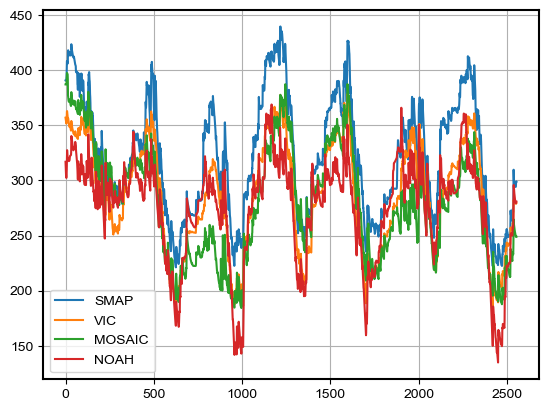

In [9]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [16]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [100, 250] # Wilting point [mm]
param_dict['awCap'] = [200, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize/soy)
param_dict['GS_start'] = [60, 152] 
param_dict['GS_end'] = [244, 334] 
param_dict['L_ini'] = [0.07, 0.22] 
param_dict['L_dev'] = [0.18, 0.33] 
param_dict['L_mid'] = [0.13, 0.38] 
param_dict['Kc_ini'] = [0.1, 0.5] 
param_dict['Kc_mid'] = [1., 1.5] 
param_dict['Kc_end'] = [0.2, 0.6] 
param_dict['Kmin'] = param_dict['Kc_ini']
param_dict['Kmax'] = param_dict['Kc_mid']
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [17]:
%%time
# RUN IT
# Historical
for obs_name in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs_name}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs_name, eval=obs_name,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name = "crop",
                      N=N,
                      save_name=save_name)
            print(save_name)

mclean_1024_SMAP_noCC
mclean_2048_SMAP_noCC
mclean_4096_SMAP_noCC
mclean_1024_NLDAS_noCC
mclean_2048_NLDAS_noCC
mclean_4096_NLDAS_noCC
CPU times: user 14min 54s, sys: 20.5 s, total: 15min 14s
Wall time: 15min 26s


In [ ]:
%%time
# RUN IT
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="crop",
                           N=N,
                           save_name=save_name)
                    print(save_name)

mclean_1024_SMAP_CCtas-5prcp0.5
mclean_1024_SMAP_CCtas-5prcp0.9
mclean_1024_SMAP_CCtas-5prcp1.1
mclean_1024_SMAP_CCtas-5prcp1.5
mclean_1024_SMAP_CCtas1prcp0.5
mclean_1024_SMAP_CCtas1prcp0.9
mclean_1024_SMAP_CCtas1prcp1.1
mclean_1024_SMAP_CCtas1prcp1.5
mclean_1024_SMAP_CCtas5prcp0.5
mclean_1024_SMAP_CCtas5prcp0.9
mclean_1024_SMAP_CCtas5prcp1.1
mclean_1024_SMAP_CCtas5prcp1.5
mclean_1024_SMAP_CCtas10prcp0.5
mclean_1024_SMAP_CCtas10prcp0.9
mclean_1024_SMAP_CCtas10prcp1.1
mclean_1024_SMAP_CCtas10prcp1.5
mclean_2048_SMAP_CCtas-5prcp0.5
mclean_2048_SMAP_CCtas-5prcp0.9
mclean_2048_SMAP_CCtas-5prcp1.1
mclean_2048_SMAP_CCtas-5prcp1.5
mclean_2048_SMAP_CCtas1prcp0.5
mclean_2048_SMAP_CCtas1prcp0.9
mclean_2048_SMAP_CCtas1prcp1.1
mclean_2048_SMAP_CCtas1prcp1.5
mclean_2048_SMAP_CCtas5prcp0.5
mclean_2048_SMAP_CCtas5prcp0.9
mclean_2048_SMAP_CCtas5prcp1.1
mclean_2048_SMAP_CCtas5prcp1.5
mclean_2048_SMAP_CCtas10prcp0.5
mclean_2048_SMAP_CCtas10prcp0.9
mclean_2048_SMAP_CCtas10prcp1.1
mclean_2048_SMAP_CCtas10

### Plots

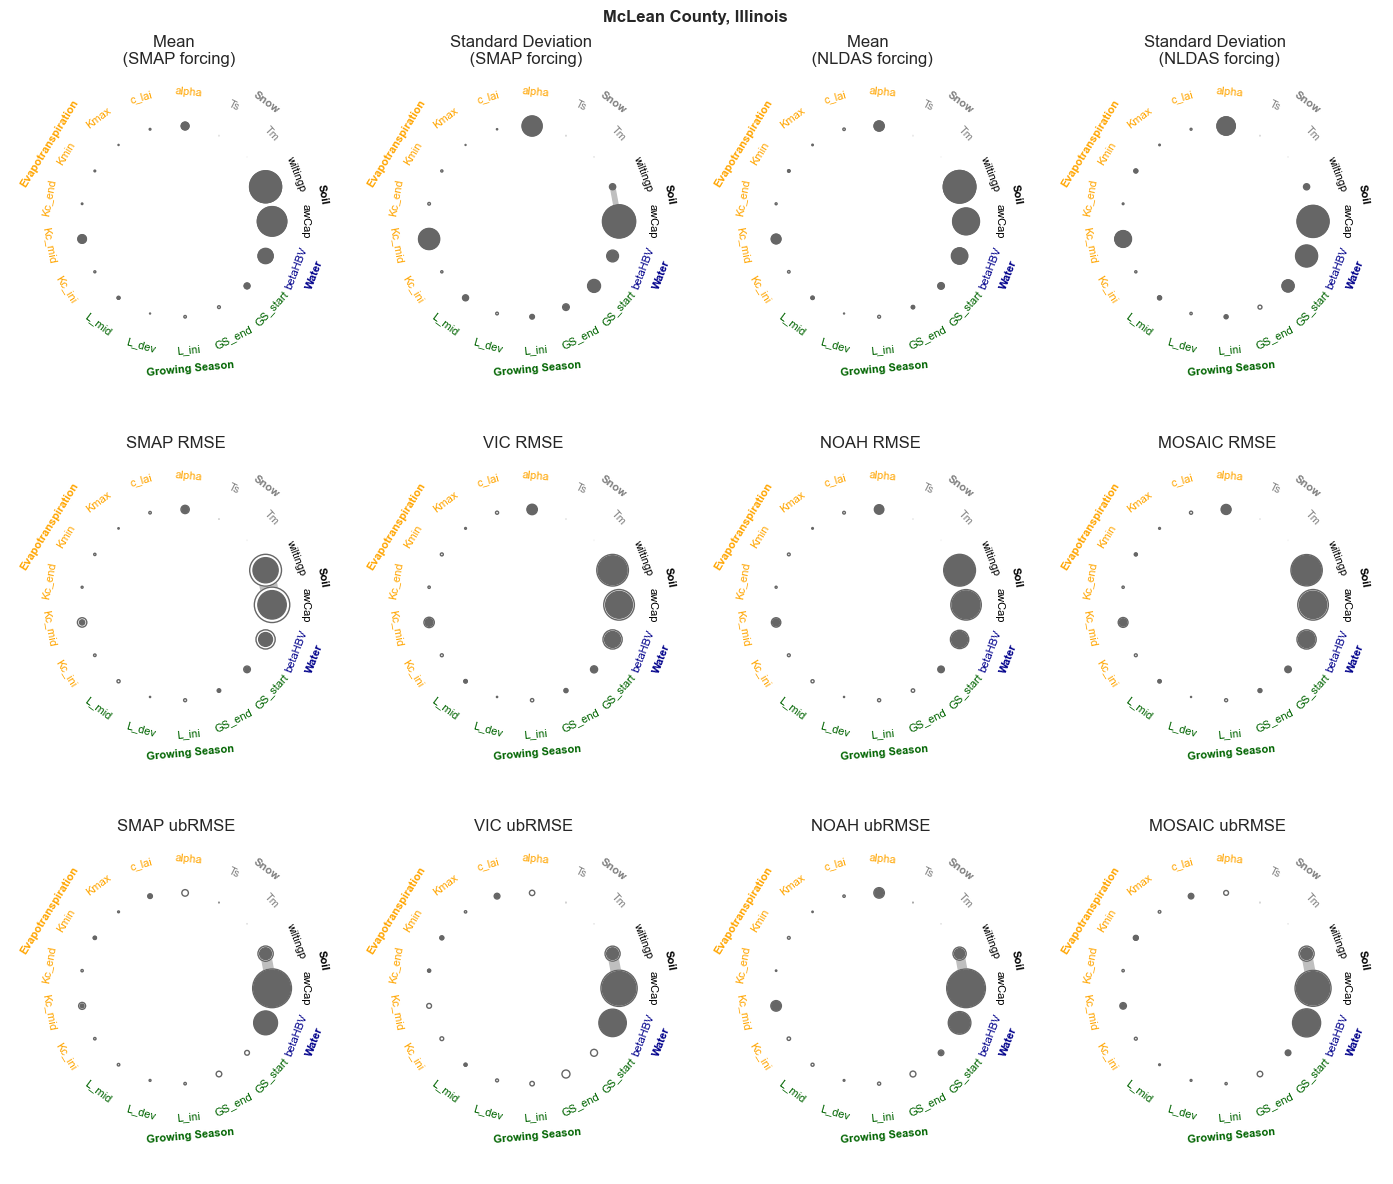

In [28]:
from utils.grouped_radial import grouped_radial
#####################
# 2nd order plot
#####################
df_smap_total, df_smap_2order = read_second_order('SMAP')
df_nldas_total, df_nldas_2order = read_second_order('NLDAS')

# Get params
groups = groups_ag.copy()
params = [groups[key] for key in groups.keys()]
params = [x for y in params for x in y]

colors = ['black', 'gray', 'orange', 'darkgreen', 'darkblue']

plt.rcParams["font.size"] = 8

###### Plot
fig, axs = plt.subplots(3,4, figsize=(14,12))

# Top Row
grouped_radial(df_smap_total.loc['mean'], df_smap_2order.loc['mean'], params, axs[0,0],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)
axs[0,0].set_title('Mean \n (SMAP forcing)', fontsize=12, y=0.9)

grouped_radial(df_smap_total.loc['sd'], df_smap_2order.loc['sd'], params, axs[0,1],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)
axs[0,1].set_title('Standard Deviation \n (SMAP forcing)', fontsize=12, y=0.9)

grouped_radial(df_nldas_total.loc['mean'], df_nldas_2order.loc['mean'], params, axs[0,2],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)
axs[0,2].set_title('Mean \n (NLDAS forcing)', fontsize=12, y=0.9)

grouped_radial(df_nldas_total.loc['sd'], df_nldas_2order.loc['sd'], params, axs[0,3],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)
axs[0,3].set_title('Standard Deviation \n (NLDAS forcing)', fontsize=12, y=0.9)

# Middle row
axs[1,0].set_title('SMAP RMSE', fontsize=12, y=0.9)
grouped_radial(df_smap_total.loc['rmse_SMAP'], df_smap_2order.loc['rmse_SMAP'], params, axs[1,0],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)

for ido, obs_name in enumerate(['VIC', 'NOAH', 'MOSAIC']):
    axs[1,1+ido].set_title(f"{obs_name} RMSE", fontsize=12, y=0.9)
    grouped_radial(df_nldas_total.loc[f'rmse_{obs_name}'], df_nldas_2order.loc[f'rmse_{obs_name}'], params, axs[1,1+ido],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)

# Bottom row
axs[2,0].set_title('SMAP ubRMSE', fontsize=12, y=0.9)
grouped_radial(df_smap_total.loc['ubrmse_SMAP'], df_smap_2order.loc['ubrmse_SMAP'], params, axs[2,0],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)

for ido, obs_name in enumerate(['VIC', 'NOAH', 'MOSAIC']):
    axs[2,1+ido].set_title(f"{obs_name} ubRMSE", fontsize=12, y=0.9)
    grouped_radial(df_nldas_total.loc[f'ubrmse_{obs_name}'], df_nldas_2order.loc[f'ubrmse_{obs_name}'], params, axs[2,1+ido],
               groups = groups_ag,
               colors = colors,
               varNameMult=1.35, gpNameMult=1.55)

fig.suptitle('McLean County, Illinois', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [15]:
# obs_name = "NLDAS"
# experiment = "mclean"
# save_name = f"{experiment}_{obs_name}_hist"

# make_hist_plot(obs_name, experiment, save_name)

In [16]:
# obs_name = "SMAP"
# experiment = "mclean"
# save_name = f"{experiment}_{obs_name}_hist"

# make_hist_plot(obs_name, experiment, save_name)

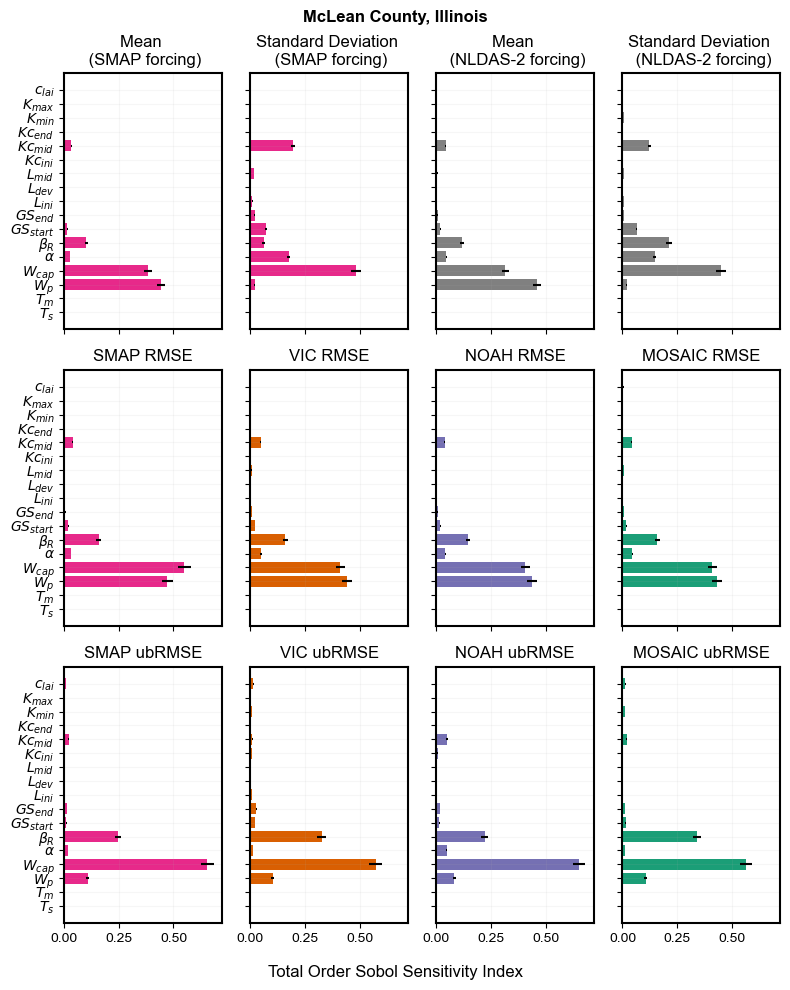

In [62]:
# Historical
experiment = "mclean"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('McLean County, Illinois', fontweight='bold')

plt.tight_layout()

plt.show()

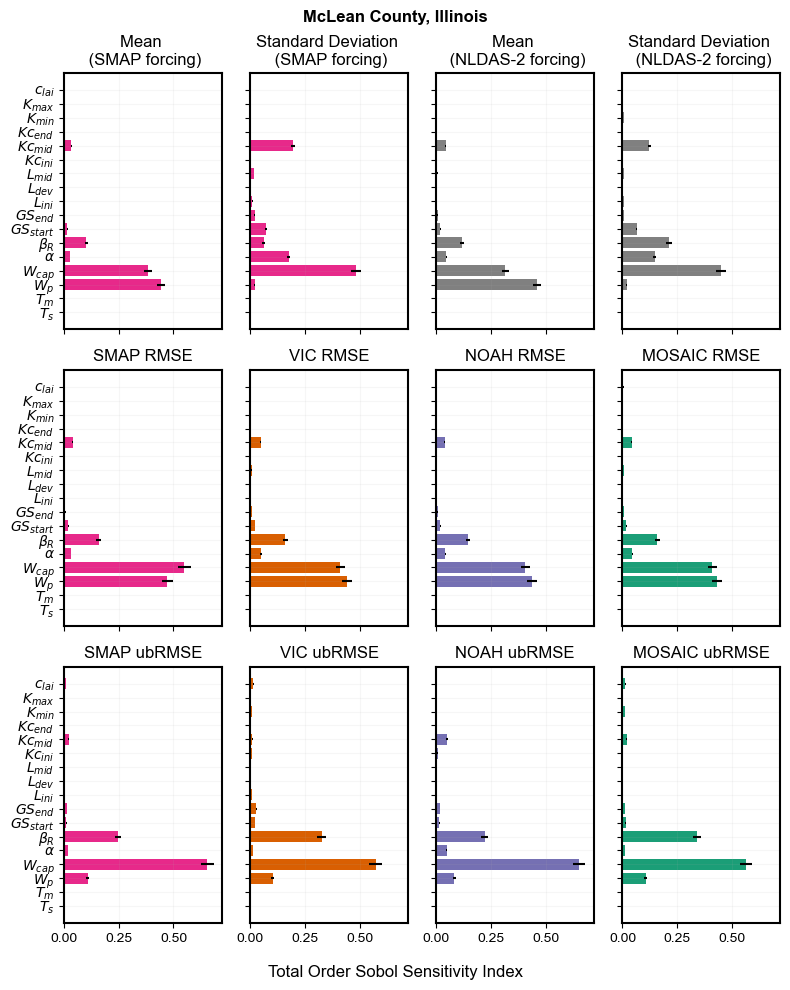

In [63]:
# Historical
experiment = "mclean"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('McLean County, Illinois', fontweight='bold')

plt.tight_layout()

plt.show()

## Smoky Mountains

### Compute

In [18]:
experiment_name = "smoky"
lat, lon = 35.61832908163286, -83.66546369858804

In [19]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

330
84


In [20]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.012658228166401386
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.9303797483444214
mixed_forest: 0.0569620244204998
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


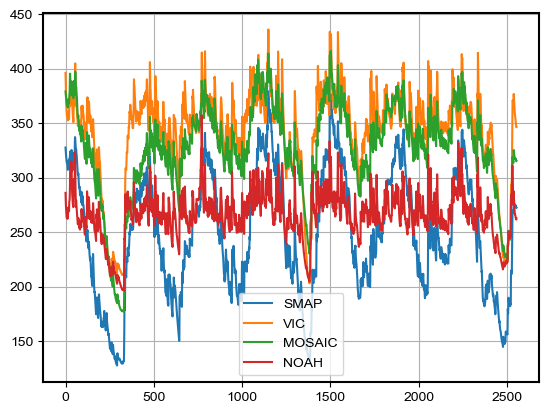

In [26]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [21]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [100, 250] # Wilting point [mm]
param_dict['awCap'] = [150, 300] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['Kmin'] = [0.1, 2]
param_dict['Kmax'] = [0.1, 2]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [22]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name="gen",
                      N=N,
                      save_name=save_name)
            print(save_name)

smoky_1024_SMAP_noCC
smoky_2048_SMAP_noCC
smoky_4096_SMAP_noCC
smoky_1024_NLDAS_noCC
smoky_2048_NLDAS_noCC
smoky_4096_NLDAS_noCC
CPU times: user 7min 47s, sys: 14.9 s, total: 8min 2s
Wall time: 8min 7s


In [ ]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="gen",
                           N=N,
                           save_name=save_name)
                    print(save_name)

### Plots

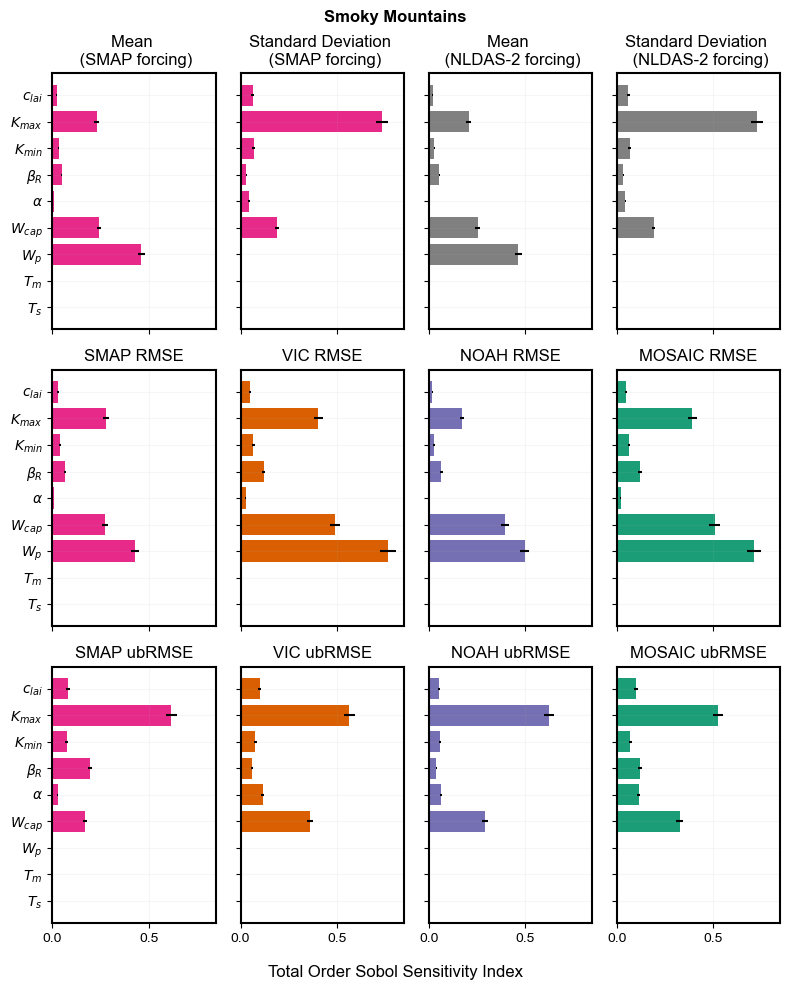

In [30]:
# Historical
experiment = "smoky"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Smoky Mountains', fontweight='bold')

plt.tight_layout()

plt.show()

## Big Bend

### Compute

In [23]:
experiment_name = "bigbend"
lat, lon = 29.22124625856724, -103.22586554830667

In [24]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

174
33


In [25]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.23699422180652618
open_shrubland: 0.6531791687011719
grassland: 0.10982658714056015
barren: 0.0
urban: 0.0


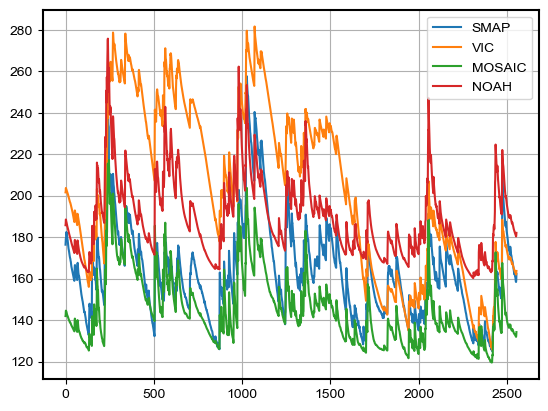

In [13]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [26]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [120, 180] # Wilting point [mm]
param_dict['awCap'] = [100, 150] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['Kmin'] = [0.1, 2]
param_dict['Kmax'] = [0.1, 2]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{experiment_name}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{experiment_name}_1024")
store_params(param_dict, 2048, f"{experiment_name}_2048")
store_params(param_dict, 4096, f"{experiment_name}_4096")

In [27]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{experiment_name}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=experiment_name,
                      Kpet_name="gen",
                      N=N,
                      save_name=save_name)
            print(save_name)

bigbend_1024_SMAP_noCC
bigbend_2048_SMAP_noCC
bigbend_4096_SMAP_noCC
bigbend_1024_NLDAS_noCC
bigbend_2048_NLDAS_noCC
bigbend_4096_NLDAS_noCC
CPU times: user 7min 52s, sys: 12.9 s, total: 8min 5s
Wall time: 8min 10s


In [ ]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 1, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{experiment_name}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    wbm_sobol(ix=ix, iy=iy,
                           forcing=obs, eval=None,
                           tas_delta=tas_delta, prcp_factor=prcp_factor,
                           experiment_name=experiment_name,
                           Kpet_name="gen",
                           N=N,
                           save_name=save_name)
                    print(save_name)

### Plots

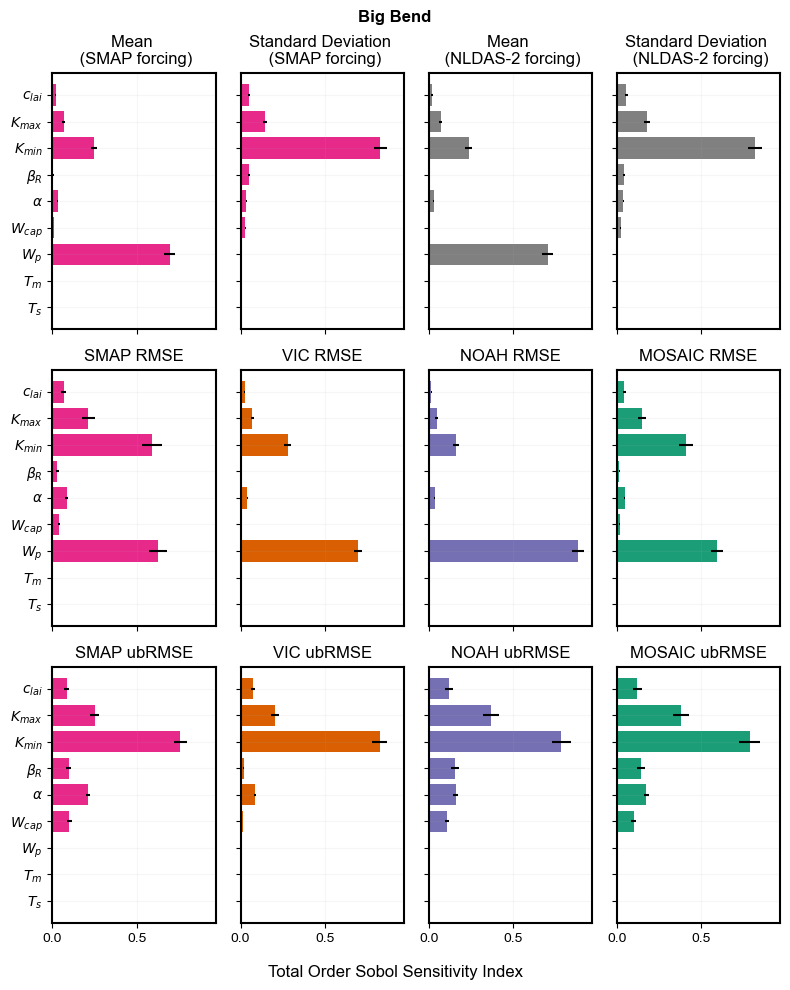

In [20]:
# Historical
experiment = "bigbend"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", False, False, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", False, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", False, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", False, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", False, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Big Bend', fontweight='bold')

plt.tight_layout()

plt.show()

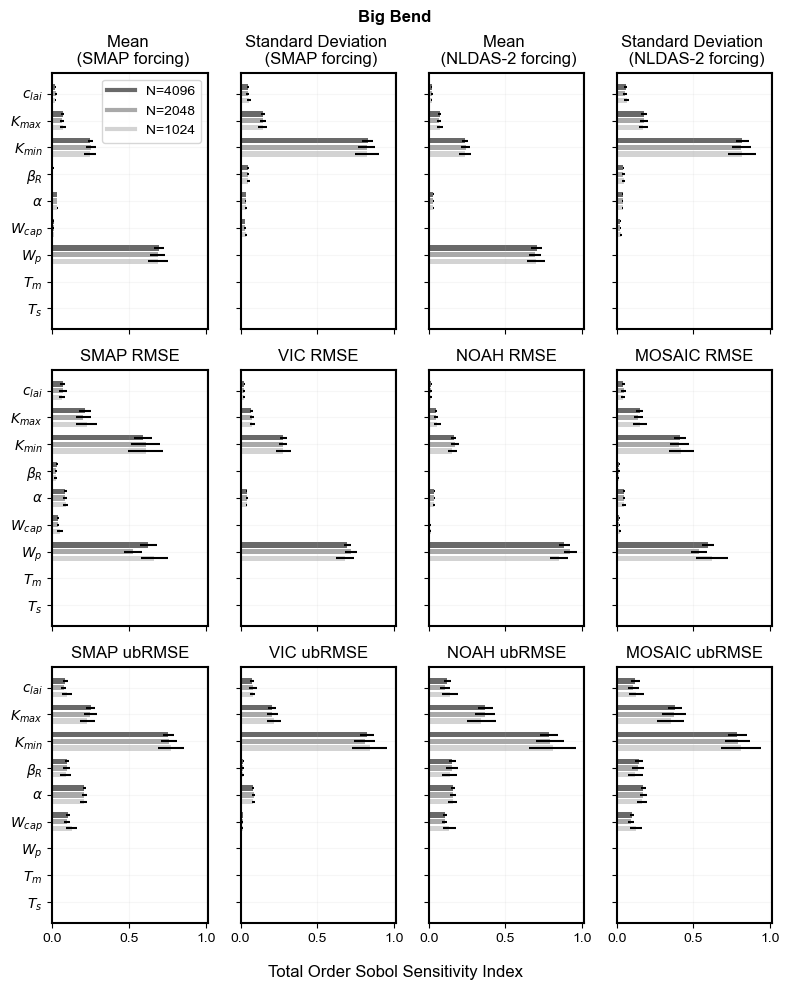

In [21]:
# Historical
experiment = "bigbend"
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
plot_sa_results(experiment, "SMAP", "mean", True, True, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
plot_sa_results(experiment, "SMAP", "sd", True, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
plot_sa_results(experiment, "NLDAS", "mean", True, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
plot_sa_results(experiment, "NLDAS", "sd", True, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"rmse_{obs_name}", True, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    plot_sa_results(experiment, obs_name, f"ubrmse_{obs_name}", True, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle('Big Bend', fontweight='bold')

plt.tight_layout()

plt.show()

# Paper plot: Figure 3

In [3]:
def plot_timeseries(coords, ax, legend):
    lat, lon = coords
    # Get location coordinates
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat

    # Get indices
    ix = (np.abs(lons - lon)).argmin().values
    iy = (np.abs(lats - lat)).argmin().values

    # x-axis
    time = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')

    # Plot
    for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
        ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
        ax.plot(time, ds_tmp[ix, iy, :], label=obs_name, color=obs_colors[obs_name])
    
    # Tidy
    if legend:
        ax.legend()
        
    ax.grid()
    ax.set_ylabel('Soil Moisture [mm]')

In [4]:
def make_sobol_plot(experiment, ax, colors):
    obs_names = ['SMAP', 'NLDAS']
    
    # Read all
    df = []
    for obs in obs_names:
        df_tmp = pd.read_csv(f'{project_data_path}/WBM/SA/{experiment}_4096_{obs}_noCC_res_total.csv')
        df_tmp = df_tmp.replace('mean', f'mean_{obs}')
        df_tmp = df_tmp.replace('sd', f'sd_{obs}')
        df_tmp = df_tmp.replace('range', f'range_{obs}')
        df.append(df_tmp)

    df = pd.concat(df)

    # Get params
    params = df['param'].unique()

    # Select and normalize
    df_plot = df[df['metric'].isin(metrics_to_include)]
    df_plot["ST_norm"] = df_plot["ST"] / df_plot.groupby("metric")["ST"].transform("sum")
    df_plot = df_plot.pivot(index='metric', columns='param', values='ST_norm')[params]
    df_plot = df_plot.reindex(metrics_to_include[::-1])

    # Plot
    df_plot.plot.barh(stacked=True, legend=False, ax=ax, color=colors)
    
    ax.set_yticklabels(ylabels[::-1])
    ax.set_ylabel('')
    ax.set_xlabel('Total Order Sobol Index (normalized)')
    ax.set_xlim([0,1])

In [5]:
# Info
experiments = ['bigbend', 'smoky', 'mclean']
coords = {'mclean': (40.61752192312278, -88.68366477345201), 
          'bigbend': (29.22124625856724, -103.22586554830667),
          'smoky': (35.61832908163286, -83.66546369858804)}

metrics_to_include = ['mean_SMAP', 'sd_SMAP', 
                      'mean_NLDAS', 'sd_NLDAS', 
                      'rmse_SMAP', 'rmse_VIC', 'rmse_NOAH', 'rmse_MOSAIC',
                      'ubrmse_SMAP', 'ubrmse_VIC', 'ubrmse_NOAH', 'ubrmse_MOSAIC']

ylabels = ['Mean (SMAP forcing)', 'Std. Dev. (SMAP forcing)',
          'Mean (NLDAS forcing)', 'Std. Dev. (NLDAS forcing)',
          'SMAP RMSE', 'VIC RMSE', 'NOAH RMSE', 'MOSAIC RMSE',
          'SMAP ubRMSE', 'VIC ubRMSE', 'NOAH ubRMSE', 'MOSAIC ubRMSE']

# Colors
colors_snow = ["#C6C6C6","#919191"]
colors_soil = ["#3669AD","#BAB3F1"]
colors_alpha = ['#C2554A']
colors_beta = ['#FCA78D']
colors_ag_pet = ["#134B42","#265737","#3A652A","#52741C","#71870B","#969206","#C5AE32","#E7CD68"]
colors_gen_pet = ["#A66694","#D486AD","#D5B2CD"]

colors_ag = colors_snow + colors_soil + colors_alpha + colors_beta + colors_ag_pet + colors_gen_pet
colors_gen = colors_snow + colors_soil + colors_alpha + colors_beta + colors_gen_pet

# Params
param_names = ['$T_s$', '$T_m$',
               '$W_p$', '$W_{cap}$',
               r'$\alpha$', r'$\beta_R$',
               '$GS_{start}$', '$GS_{end}$', '$L_{ini}$', '$L_{dev}$', '$L_{mid}$', '$Kc_{ini}$', '$Kc_{mid}$', '$Kc_{end}$',
                '$K_{min}$','$K_{max}$', '$c_{lai}$']

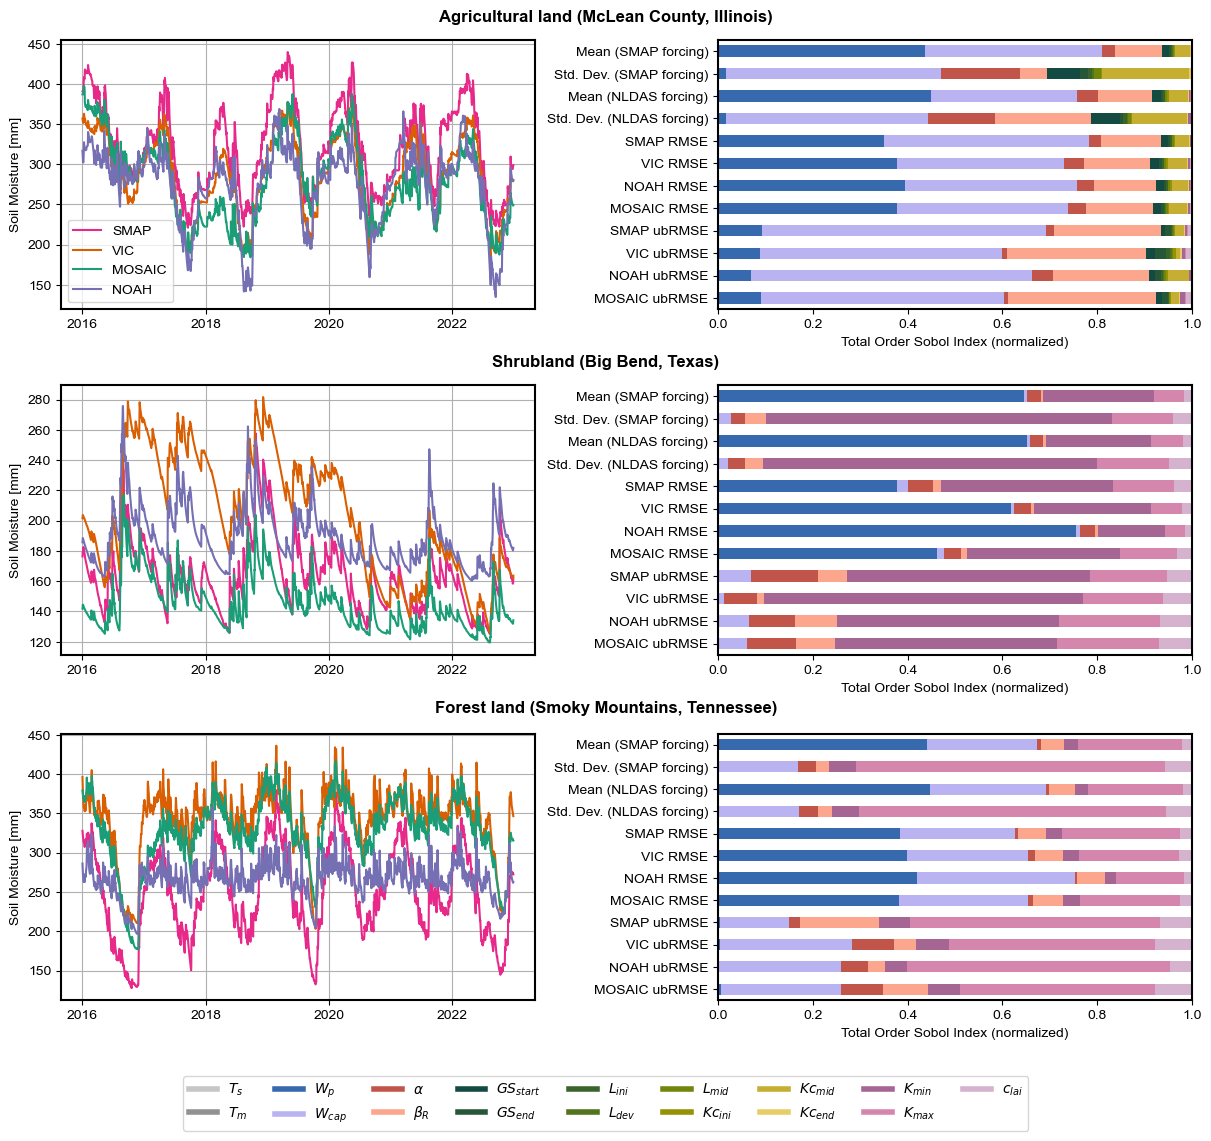

In [7]:
fig = plt.figure(layout='constrained', figsize=(12,11))
subfigs = fig.subfigures(4, 1, hspace=0.1, height_ratios = [5,5,5,1])

# McLean
subfigs[0].suptitle('Agricultural land (McLean County, Illinois)', fontweight='bold', y=1.08)
axs = subfigs[0].subplots(1, 2)
experiment = "mclean"
plot_timeseries(coords[experiment], axs[0], True)
make_sobol_plot(experiment, axs[1], colors_ag)

# Big Bend
subfigs[1].suptitle('Shrubland (Big Bend, Texas)', fontweight='bold', y=1.08)
axs = subfigs[1].subplots(1, 2)
experiment = "bigbend"
plot_timeseries(coords[experiment], axs[0], False)
make_sobol_plot(experiment, axs[1], colors_gen)

# Smoky
axs = subfigs[2].subplots(1, 2)
subfigs[2].suptitle('Forest land (Smoky Mountains, Tennessee)', fontweight='bold', y=1.08)
experiment = "smoky"
plot_timeseries(coords[experiment], axs[0], False)
make_sobol_plot(experiment, axs[1], colors_gen)

# Legend
ax = subfigs[3].subplots(1, 1)
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors_ag]
ax.legend(custom_lines, param_names, ncol = 9, loc='center')
ax.set_axis_off()

plt.savefig('../figs/main/fig3_initial_sa.pdf', bbox_inches='tight')